In [247]:
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact
import requests
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Cordia New'
plt.rc('axes', unicode_minus=False)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'




In [248]:

url_loan = "https://data.go.th/dataset/ee2d5c24-e132-48fa-b7dd-254b281440d7/resource/55c6fc3b-ce11-4f45-8a63-fa5cb9cd67fd/download/2564-2565-66.xlsx"
url_payer = "https://data.go.th/dataset/1f36630a-c9d2-4ee6-86ea-4f7f93af4761/resource/58e64a92-7b1f-4453-bc8e-f7397c5a9606/download/untitled.xlsx"
url_status = "https://data.go.th/dataset/191983d1-3e59-4bf1-8d6d-6f5cb5c54c8f/resource/551865fe-7277-4213-b307-3cd374270441/download/_66.xlsx"

# Data preparation

## ข้อมูลผลการกู้ กยศ แยกตามพื้นที่ปี 2564 - 2565


In [249]:
df_loan = pd.read_excel(url_loan)
df_loan.head()

,ปีการศึกษา,ลักษณะการกู้ยืม,ตำบล,อำเภอ,จังหวัด,จำนวนผู้กู้ยืมทั้งหมด,จำนวนผู้กู้ยืมค่าครองชีพ,จำนวนเงินค่าเล่าเรียนค่าใช้จ่ายเกี่ยวเนื่อง,จำนวนเงินค่าครองชีพ
0,2564,1,เกาะกลาง,เกาะลันตา,กระบี่,166,166,3098573.0,5142000
1,2564,1,เกาะลันตาน้อย,เกาะลันตา,กระบี่,62,61,1140795.0,1922400
2,2564,1,เกาะลันตาใหญ่,เกาะลันตา,กระบี่,85,85,1609466.0,2618400
3,2564,1,คลองยาง,เกาะลันตา,กระบี่,111,111,2050103.0,3532800
4,2564,1,ศาลาด่าน,เกาะลันตา,กระบี่,58,57,1491128.0,1903200


ประกอบไปด้วยจำนวนแถว 33,943 แถว และจำนวนคอลัมน์ 9 คอลัมน์
### Data type ของแต่ละคอลัมน์มีดังนี้ : 
1. ปีการศึกษา : int64
2. ลักษณะการกู้ยืม : int64
3. ตำบล : object
4. อำเภอ : object
5. จังหวัด : object
6. จำนวนผู้กู้ยืมทั้งหมด : int64 
7. จำนวนเงินค่าเล่าเรียนค่าใช้จ่ายเกี่ยวเนื่อง : int64 
8. จำนวนเงินค่าครองชีพ : int64 

* ไม่มี null value

ข้อมูลเชิงกลุ่มที่ต้องการการอธิบาย : ลักษณะการกู้ยืม
* 1 หมายถึง ขาดแคลนทุนทรัพย์
* 2 หมายถึง ศึกษาในสาขาวิชาที่เป็นวามต้องการหลัก
* 3 หมายถึง ศึกษาในสาขาวิชาขาดแคลน
* 4 หมายถึง เรียนดี

In [250]:
# เพิ่มคอลัมน์ ผลรวมการกู้

df_loan['ผลรวมการกู้'] = df_loan['จำนวนเงินค่าเล่าเรียนค่าใช้จ่ายเกี่ยวเนื่อง']+ df_loan['จำนวนเงินค่าครองชีพ']
df_loan = df_loan[df_loan['ปีการศึกษา'] != 2564]
df_loan = df_loan.drop(['ลักษณะการกู้ยืม','ตำบล','อำเภอ','ปีการศึกษา'],axis=1)
summed_df_loan = df_loan.groupby('จังหวัด').sum().reset_index()
summed_df_loan.head()

,จังหวัด,จำนวนผู้กู้ยืมทั้งหมด,จำนวนผู้กู้ยืมค่าครองชีพ,จำนวนเงินค่าเล่าเรียนค่าใช้จ่ายเกี่ยวเนื่อง,จำนวนเงินค่าครองชีพ,ผลรวมการกู้
0,กระบี่,6694,6545,1.784679e+08,210918000,3.893859e+08
1,กรุงเทพมหานคร,38874,33705,1.600046e+09,1108494000,2.708540e+09
2,กาญจนบุรี,7122,6884,1.712062e+08,219930000,3.911362e+08
3,กาฬสินธุ์,9361,9051,2.276785e+08,288254400,5.159329e+08
4,กำแพงเพชร,7239,6990,1.503932e+08,219867600,3.702608e+08


## ข้อมูลประเภทของผู้กู้ กยศ ของแต่ละพื้นที่ แยกตามสถานะปลอดหนี้และสถานะชำระหนี้ 2564 - 2565 


In [251]:
df_payer = pd.read_excel(url_payer)
df_payer = df_payer[df_payer['ปีงบประมาณ'] != 2564]
df_payer = df_payer.drop(['ลักษณะการให้กู้ยืม','ตำบล','อำเภอ','ปีงบประมาณ'],axis=1)
df_payer.head()

,สถานะผู้กู้,จังหวัด,จำนวนผู้กู้,จำนวนเงินกู้
29240,อยู่ระหว่างชำระหนี้,กระบี่,658,92033565.22
29241,อยู่ระหว่างชำระหนี้,กระบี่,391,54801093.67
29242,อยู่ระหว่างชำระหนี้,กระบี่,355,47756918.55
29243,อยู่ระหว่างชำระหนี้,กระบี่,414,54755402.16
29244,อยู่ระหว่างชำระหนี้,กระบี่,306,46195512.96


หลังจากตัดข้อมูลปี 2564 ออก และตัดคอลัมน์ ลักษณะการให้กู้ยืม ตำบล อำเภอ และปีงบประมาณแล้ว\
ประกอบไปด้วยจำนวนแถว 29,674 แถว และจำนวนคอลัมน์ 4 คอลัมน์

* Data type ของแต่ละคอลัมน์มีดังนี้ : 
1. สถานะผู้กู้ : object
5. จังหวัด : object
6. จำนวนผู้กู้ : int64
7. จำนวนเงินค่าเล่าเรียนค่าใช้จ่ายเกี่ยวเนื่อง : int64 
8. จำนวนเงินค่าครองชีพ : int64 

* ไม่มี null value

In [265]:
# จัดกลุ่มข้อมูลแยกตามจังหวัดและสถานะผู้กู้

grouped_df_payer = df_payer.groupby(['จังหวัด','สถานะผู้กู้']).sum().reset_index()
grouped_df_payer.head(6)

,จังหวัด,สถานะผู้กู้,จำนวนผู้กู้,จำนวนเงินกู้
0,กระบี่,อยู่ระหว่างชำระหนี้,24429,3.271592e+09
1,กระบี่,อยู่ระหว่างปลอดหนี้,2908,4.199499e+08
2,กรุงเทพมหานคร,อยู่ระหว่างชำระหนี้,224711,3.666218e+10
3,กรุงเทพมหานคร,อยู่ระหว่างปลอดหนี้,21021,3.876196e+09
4,กาญจนบุรี,อยู่ระหว่างชำระหนี้,40206,5.060806e+09
5,กาญจนบุรี,อยู่ระหว่างปลอดหนี้,3790,5.731595e+08


In [253]:
# เตรียมข้อมูลสำหรับสร้างกราฟ

summed_df_payer = grouped_df_payer.groupby('สถานะผู้กู้')['จำนวนผู้กู้'].sum().reset_index()
summed_df_payer

,สถานะผู้กู้,จำนวนผู้กู้
0,อยู่ระหว่างชำระหนี้,3546218
1,อยู่ระหว่างปลอดหนี้,346014


## ข้อมูลสถานะผู้กู้ กยศ แบ่งตามสถานะ

In [254]:
df_status = pd.read_excel(url_status)
df_status

,ลำดับสถานะ,สถานะผู้กู้ยืม,จำนวนผู้กู้ยืม(รายบัญชี),จำนวนเงินกู้ยืม(บาท),จำนวนเงินต้นผิดนัดชำระหนี้(บาท)
0,10,1.อยู่ระหว่างศึกษา ปลอดหนี้,1366838,1.432988e+11,0.000000e+00
1,20,2.อยู่ระหว่างชำระหนี้,3519163,4.518960e+11,9.736006e+10
2,21,2.1ไม่ผิดนัดชำระหนี้,1277319,1.889971e+11,0.000000e+00
3,22,2.2ผิดนัดชำระหนี้,2241844,2.628990e+11,9.736006e+10
4,30,3.ชำระหนี้เสร็จสิ้น,1848558,1.457144e+11,0.000000e+00
5,40,4.เสียชีวิต ทุพพลภาพ,72270,6.391653e+09,0.000000e+00


# ภาพรวมของ กยศ ในปัจจุบัน

In [269]:
summed_df_loan

,จังหวัด,จำนวนผู้กู้ยืมทั้งหมด,จำนวนผู้กู้ยืมค่าครองชีพ,จำนวนเงินค่าเล่าเรียนค่าใช้จ่ายเกี่ยวเนื่อง,จำนวนเงินค่าครองชีพ,ผลรวมการกู้
0,กระบี่,6694,6545,1.784679e+08,210918000,3.893859e+08
1,กรุงเทพมหานคร,38874,33705,1.600046e+09,1108494000,2.708540e+09
2,กาญจนบุรี,7122,6884,1.712062e+08,219930000,3.911362e+08
3,กาฬสินธุ์,9361,9051,2.276785e+08,288254400,5.159329e+08
4,กำแพงเพชร,7239,6990,1.503932e+08,219867600,3.702608e+08
...,...,...,...,...,...,...
72,เพชรบุรี,3782,3625,1.057043e+08,115837200,2.215415e+08
73,เพชรบูรณ์,10312,10017,2.299356e+08,321106800,5.510424e+08
74,เลย,4245,4065,1.130181e+08,129832800,2.428509e+08
75,แพร่,4737,4598,9.632015e+07,146004000,2.423241e+08


In [278]:
summed_df_loan.iloc[:, 1].min()
summed_df_loan.iloc[:, 1].max()
summed_df_loan.iloc[:, 1].mean()
summed_df_loan.iloc[:, 1].median()
summed_df_loan.iloc[:, 1].mode()


0      1667
1      1679
2      1822
3      1902
4      2159
      ...  
72    18295
73    20639
74    20827
75    23932
76    38874
Name: จำนวนผู้กู้ยืมทั้งหมด, Length: 77, dtype: int64

Text(0.5, 1.0, 'ฮิสโตแกรมแสดงความถี่ของผู้กู้ยืม กยศ. แยกตามจังหวัด')

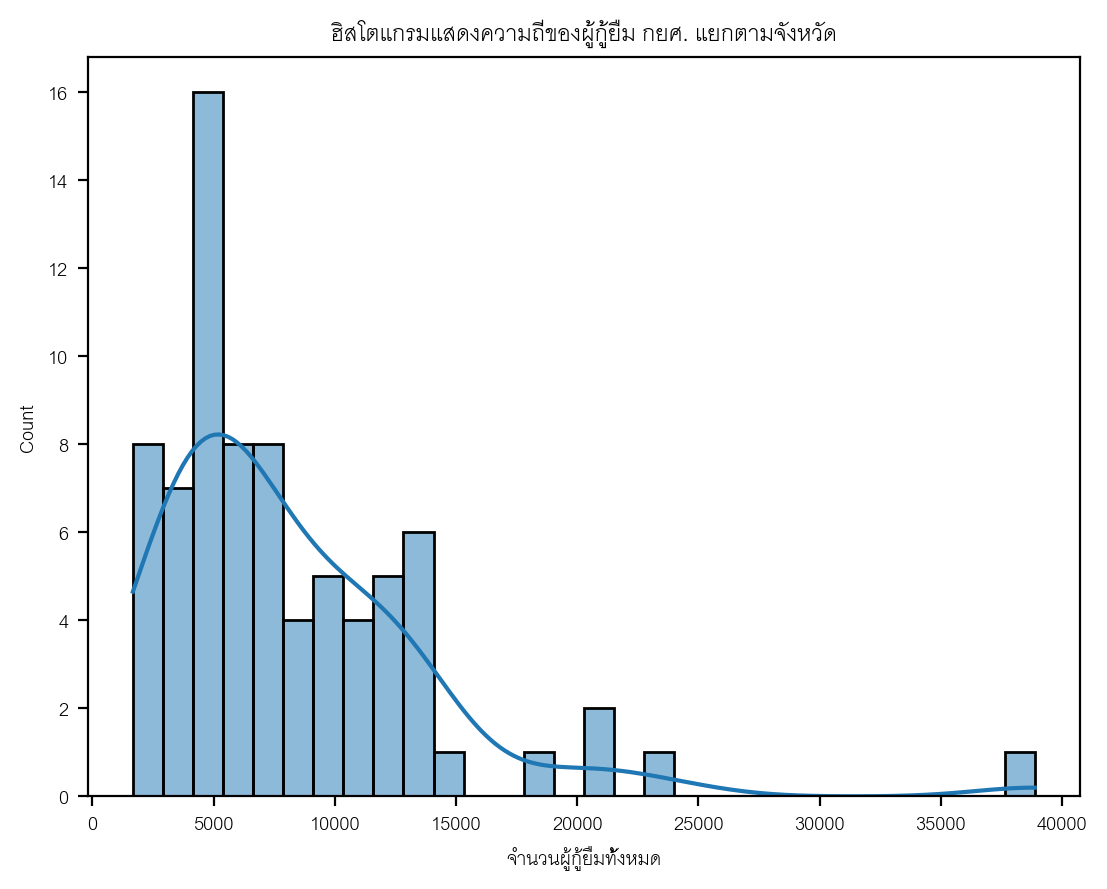

In [256]:
fig1 = sns.histplot(data=summed_df_loan, x="จำนวนผู้กู้ยืมทั้งหมด",kde=True,bins=30,)
fig1.set_title('ฮิสโตแกรมแสดงความถี่ของผู้กู้ยืม กยศ. แยกตามจังหวัด')

จากกราฟจะแสดงให้เห็นว่าการกระจายตัวข้อมูลในส่วนของจำนวนผู้กู้ยืม กยศ. มีลักษณะเบ้ขวา และมี Outlier

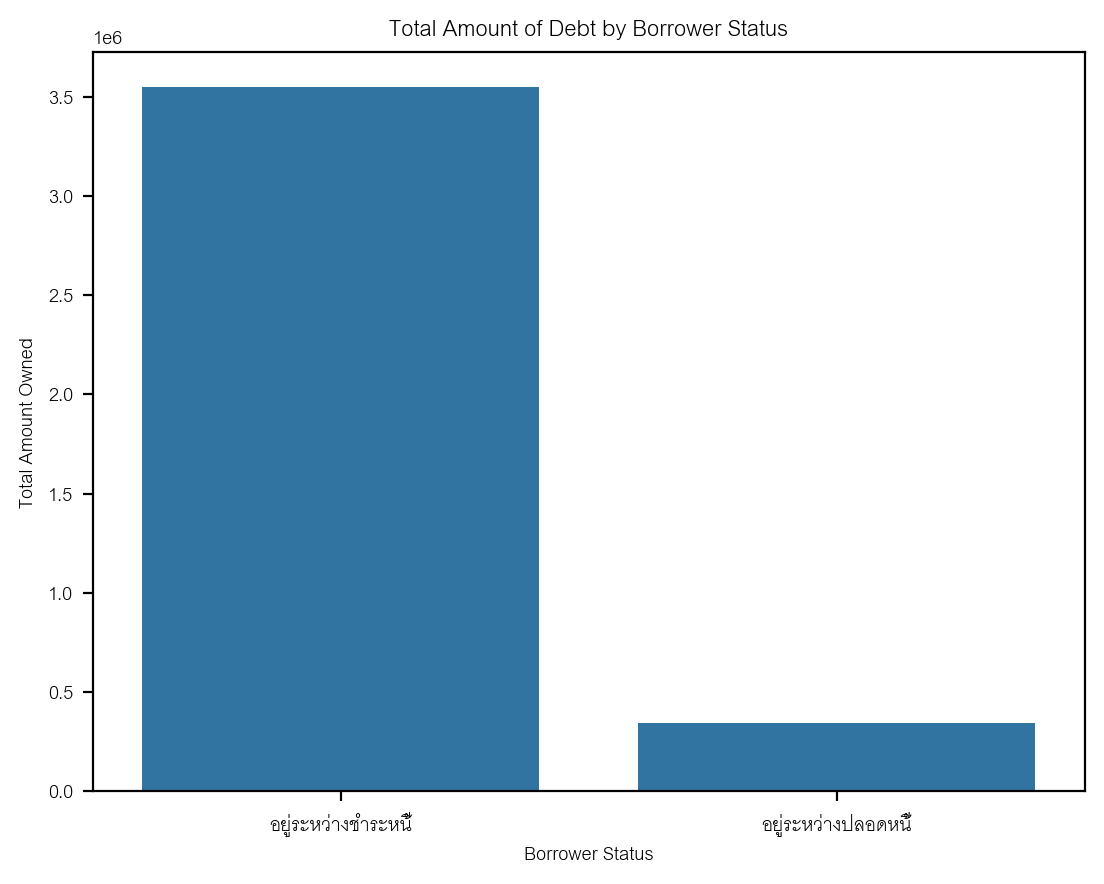

In [260]:
sns.barplot(data = summed_df_payer,x='สถานะผู้กู้',y='จำนวนผู้กู้')
plt.title('Total Amount of Debt by Borrower Status')
plt.xlabel('Borrower Status')
plt.ylabel('Total Amount Owned')

plt.show()

In [261]:
def update_plot(selected_province):
    # Filter the DataFrame for the selected province
    filtered_df = grouped_df_payer[grouped_df_payer['จังหวัด'] == selected_province]
    
    # Prepare the first plot data: Group by 'สถานะผู้กู้' and sum 'จำนวนผู้กู้'
    borrowers_df = filtered_df.groupby('สถานะผู้กู้')['จำนวนผู้กู้'].sum().reset_index()
    
    # Prepare the second plot data: Group by 'สถานะผู้กู้' and sum 'จำนวนเงินกู้'
    amount_owned_df = filtered_df.groupby('สถานะผู้กู้')['จำนวนเงินกู้'].sum().reset_index()
    
    # # Clear previous output (if any)
    # clear_output(wait=True)
    # display(province_dropdown)  # Display the dropdown again
    
    # Setup the figure for two subplots
    plt.figure(figsize=(14, 6))
    
    # First plot for number of borrowers
    plt.subplot(1, 2, 1) # (rows, columns, panel number)
    sns.barplot(x='สถานะผู้กู้', y='จำนวนผู้กู้', data=borrowers_df)
    plt.title(f'Number of Borrowers in {selected_province}')
    plt.xlabel('Borrower Status')
    plt.ylabel('Total Number of Borrowers')
    
    # Second plot for amount owned
    plt.subplot(1, 2, 2)
    sns.barplot(x='สถานะผู้กู้', y='จำนวนเงินกู้', data=amount_owned_df)
    plt.title(f'Total Amount Owned in {selected_province}')
    plt.xlabel('Borrower Status')
    plt.ylabel('Total Amount Owned')
    
    plt.tight_layout()
    plt.show()
    # Create a dropdown for province selection
province_dropdown = widgets.Dropdown(
    options=grouped_df_payer['จังหวัด'].unique(),
    description='Province:',
    disabled=False,
)

# Display the dropdown and update the plot function upon selection
widgets.interactive(update_plot, selected_province=province_dropdown)

interactive(children=(Dropdown(description='Province:', options=('กระบี่', 'กรุงเทพมหานคร', 'กาญจนบุรี', 'กาฬส…

In [262]:
df_status = df_status[['สถานะผู้กู้ยืม','จำนวนผู้กู้ยืม(รายบัญชี)']]
df_default_rate = df_status.iloc[[2,3], :]
df_default_rate['สัดส่วน'] = df_default_rate.iloc[: , 1] / df_default_rate.iloc[: ,1 ].sum()

C:\Users\Purachai\AppData\Local\Temp\ipykernel_13920\3865713.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_default_rate['สัดส่วน'] = df_default_rate.iloc[: , 1] / df_default_rate.iloc[: ,1 ].sum()


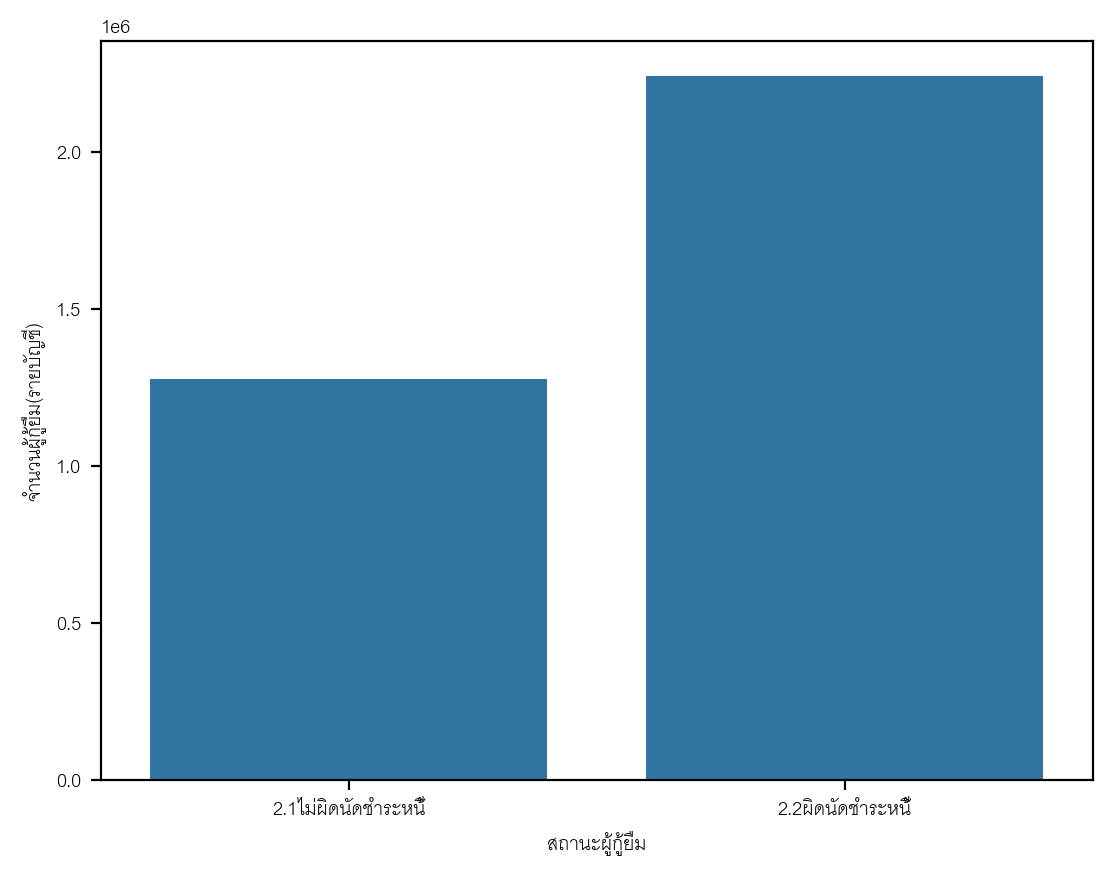

In [263]:
fig3 = sns.barplot(data = df_status.iloc[[2,3], :], x = 'สถานะผู้กู้ยืม', y = 'จำนวนผู้กู้ยืม(รายบัญชี)' )

![sss](https://www.studentloan.or.th/sites/default/files/images/news/%E0%B8%82%E0%B9%88%E0%B8%B2%E0%B8%A7.jpg)